# Contribution
- Pei Xuan - Researching, data cleaning, explanations for Task 1 & 2 
- Jia Hui - Researching, data cleaning, model experimenting for Task 1 & 2 
- Jonathan - Researching, data cleaning, excel computations
- Min Khant - Researching, model experimenting for Task 1
- Alyssa - Researching

# Required Imports

In [165]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Functions

In [166]:
def normalize_z(df):
    # mean with axis 0 is summing the rows
    return (df - df.mean(axis=0)) / df.std(axis=0) 

def get_features_targets(df, feature_names, target_names):
    df_feature = df[feature_names]
    df_target = df[target_names]
    return df_feature, df_target

def prepare_feature(df_feature):
    cols = len(df_feature.columns) 
    feature = df_feature.to_numpy()
    number_of_samples = feature.shape[0]
    return np.concatenate((np.ones((number_of_samples,1)), feature), axis=1)

def prepare_target(df_target):
    # to_numpy() removes the first column (header column)
    return df_target.to_numpy()

def predict(df_feature, beta):
    X = prepare_feature(normalize_z(df_feature))
    return predict_norm(X, beta)

def predict_norm(X, beta):
    return np.matmul(X,beta)

def split_data(df_feature, df_target, random_state=100, test_size=0.3):
    # get the indexes of the feature 
    indexes = df_feature.index
    # seed the random value 
    if random_state != None:
        np.random.seed(random_state)
    # get the number of test samples to extract 
    k = int(test_size * len(indexes))
    # get the indexes from the features and target to select as test set 
    test_index = np.random.choice(indexes, k, replace=False)
    indexes = set(indexes)
    test_index = set(test_index)
    train_index = indexes - test_index
    df_feature_train = df_feature.loc[train_index, :]
    df_feature_test = df_feature.loc[test_index, :]
    df_target_train = df_target.loc[train_index, :]
    df_target_test = df_target.loc[test_index, :]
    return df_feature_train, df_feature_test, df_target_train, df_target_test

def r2_score(y, ypred):
    sum_res = np.sum((y - ypred)**2)
    error_tot = y - np.mean(y)
    sum_tot = np.sum(error_tot**2)
    return 1-(sum_res/sum_tot)

def adjusted_r2_score(y, ypred, p):
    r2 = r2_score(y, ypred)
    N = y.shape[0]
    x = (1 - r2) * (N - 1)
    y = N - p - 1
    return 1 - ( x/y )

def root_mean_squared_error(target, pred):
    n = target.shape[0]
    mse = 1/n * np.sum((target-pred)**2)
    return np.sqrt(mse)

def compute_cost(X, y, beta):
    J = 0
    no_of_samples = X.shape[0]
    error = np.matmul(X, beta) - y
    error_sq = np.matmul(error.T, error) # .T is transpose
    J = 1/(2*no_of_samples) * error_sq
    return J[0][0]

def gradient_descent(X, y, beta, alpha, num_iters):
    number_of_samples = X.shape[0]
    J_storage = []
    for i in range(num_iters):
        # STEP 2: compute the derivate with current parameters
        derivative_error = (1/(number_of_samples)) * np.matmul(X.T, (np.matmul(X, beta) - y))
        # STEP 3: update the parameters
        beta = beta - alpha *  derivative_error
        # compute cost at every iteration of beta
        J_storage.append(compute_cost(X, y, beta))
    return beta, J_storage

def transform_features_power(df_feature, colname, colname_transformed, value):
    copy = df_feature.copy()
    copy.loc[:, colname_transformed] = df_feature.loc[:,colname] ** value 
    return copy

def printBeta(beta):
    stringDisplay = "The beta values are "
    for i in range(beta.shape[0]):
        if i == beta.shape[0]-1:
            stringDisplay += str(round(beta[i][0], 2)) + "."
            break
        stringDisplay += str(round(beta[i][0], 2)) + ", "
    print(stringDisplay) 

# 2D TASK 1

## Collected Information

We collected the data that relates to death cases of Covid-19 from 38 countries. 

Factors affecting death rate:
   - The Number of Covid Cases (Cumulative Total & Cumulative Total per 100000 population as of 10 Nov 2021) 
   - Percentage of Population Fully/Partially Vaccinated as of 10 Nov 2021
   - Percentage of Population Aged 65 or Above
   - Use of Tobacco
   - Percentage of Population with Obesity
   - Physician Density Per 1000
   - The Number of Covid Tests
   - Gross National Income
   - Human Development Index
   - Life Expectancy
   - Total Population
   - Urban Population


After running several excel computations and visualisations, we found that these are the most relevant to total death cases. So, we decided to use them as predictors. 
   
   1. The Number of Covid Cases
   2. Percentage of Population Aged 65 or Above
   
You can see the visualisations by running the following codes.

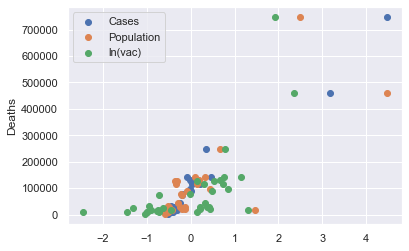

In [167]:
df_task1 = pd.read_csv("DDW_Task1.csv")
df_features, df_target = get_features_targets(df_task1, ["Cases", "Population", "ln(vac)"], ["Deaths"])

# Visualise
df_features_visual = normalize_z(df_features)
plt.scatter(df_features_visual["Cases"], df_target, label="Cases")
plt.scatter(df_features_visual["Population"], df_target, label="Population")
plt.scatter(df_features_visual["ln(vac)"], df_target, label="ln(vac)")
plt.ylabel("Deaths")
plt.legend()
plt.show()

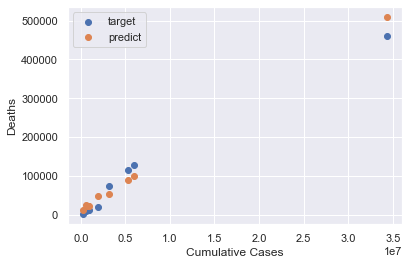

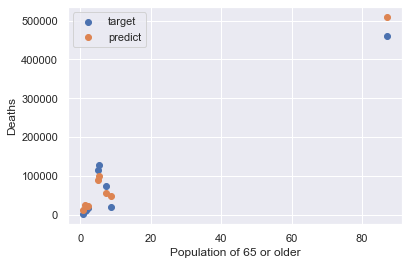

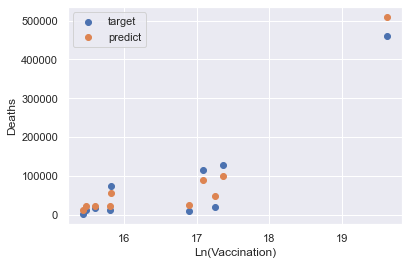

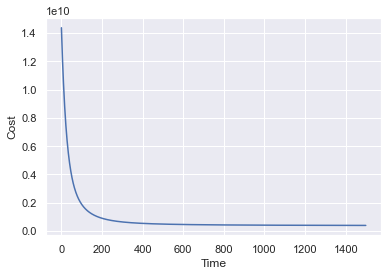

In [168]:
#spliting the data for trainging and testing
df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_features, df_target)

# normalize features
df_features_train_z = normalize_z(df_features_train)

# change to numpy array and append column for feature
X = prepare_feature(df_features_train_z)
target = prepare_target(df_target_train)

iterations = 1500
alpha = 0.01
beta = np.zeros((4,1))

# call gradient_descent() function
beta, J_storage = gradient_descent(X, target, beta, alpha, iterations)

pred = predict(df_features_test, beta)
target = prepare_target(df_target_test)

plt.scatter(df_features_test["Cases"], target, label="target")
plt.scatter(df_features_test["Cases"], pred, label="predict")
plt.xlabel("Cumulative Cases")
plt.ylabel("Deaths")
plt.legend()
plt.show()

plt.scatter(df_features_test["Population"], target, label="target")
plt.scatter(df_features_test["Population"], pred, label="predict")
plt.xlabel("Population of 65 or older")
plt.ylabel("Deaths")
plt.legend()
plt.show()

plt.scatter(df_features_test["ln(vac)"], target, label="target")
plt.scatter(df_features_test["ln(vac)"], pred, label="predict")
plt.xlabel("Ln(Vaccination)")
plt.ylabel("Deaths")
plt.legend()
plt.show()

plt.plot(J_storage)
plt.xlabel("Time")
plt.ylabel("Cost")
plt.show()

In [169]:
# TESTS
printBeta(beta)

a_r2 = adjusted_r2_score(target, pred, beta.shape[0]-1)
print("The Adjusted R Squared Value is", round(a_r2, 2))

mse = root_mean_squared_error(target, pred)
print("The Root Mean Squared Error Value is", round(mse, 2))


The beta values are 90321.77, 132899.64, 11593.51, 7053.52.
The Adjusted R Squared Value is 0.95
The Root Mean Squared Error Value is 24113.35



- By using Multiple Linear Regression Model, we are able to predict the number of deaths for a country with 96% accuracy. In order to get this accuracy, we had checked the R squared values of the individual feature with our target (number of death). We have plotted the our model predictions with the target test values which allows us to see how well our predictions is. 

# 2D TASK 2

## Problem Statement

We aim to predict the **daily number of COVID-19 patients** admitted to hospitals in the UK using:

1. **Number of days** from the introduction of the Delta variant to the UK
2. **Vaccination Rate** in the UK
3. **Number of visitors** to Transit Areas

## Relevance
Having an accurate prediction of daily hospital admissions is important for the UK government to ensure sufficient hospital capacity for COVID-19 patients. Due to limitations in public funds, the UK government cannot afford to ramp up hospital capacity beyond what is necessary as this would lead to the wastage of public funds and the underutilization of healthcare resources. Therefore, in order to optimize its resource usage while at the same time preventing the healthcare system from being overstrained, the UK government would require an accurate prediction of daily hospital admissions. Sufficient hospital capacity is a precondition for the safe and successful re-opening of the UK economy and hence, our problem statement is highly relevant to the UK government.



## The Design Opportunity (Discussion on Predictors)

Through our research and explorations using the data, we found that using the number of days from the introduction of the Delta variant to the UK and the vaccination rate enable for more accurate predictions.
This is expected because:

Delta Variant: 
- The time since the introduction of Delta Variant is a significant factor as the Delta variant is more infectious and leads to increased disease severity. A longer time period during which the Delta variant is spreading would represent greater transmission of the Delta variant and more people being sick enough to require hospital admission.

Vaccination rates:
- This also serve as a strong predictor of daily hospital admissions because vaccinations decrease disease severity to a large extent.

Number of visitors to Transit Areas:
- The number of visitors to transit stations serves as a measure for the extent of economic reopening which in turn affects the transmission risk. As an increased scale of economic reopening is associated with greater transmission of the virus, it is a significant factor for consideration.


## Link to Data Sources
### 
- [Hospital Admissions](https://coronavirus.data.gov.uk/details/healthcare)

- [Vaccination Rate](https://coronavirus.data.gov.uk/details/vaccinations)

- [Number of visitors](https://ourworldindata.org/grapher/visitors-transit-covid)

- [Start of Delta Variant -> '1/5/2021 as Day 0'](https://www.bbc.com/news/health-57489740)

## Cleaning of Data

1. Took data from 1/5/2021 to 8/11/2021
2. Remove outliers
3. Checked for duplicates
4. Checked for empty cells
5. Arrange data according to date

## All possible models
1. **[Linear Regression](#linear)**
2. **[Polynomial Regression](#poly)**
1. **[Mutiple Regression](#multi)**

## Reading data from CSV

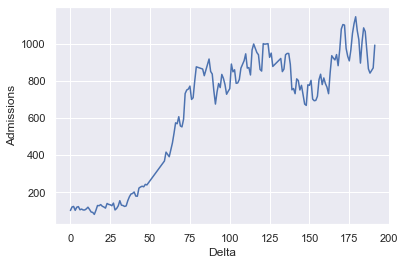

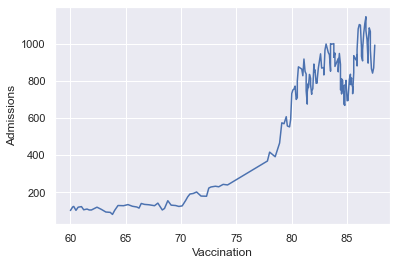

In [170]:

import matplotlib.dates as mdates
df = pd.read_csv("DDW_Task2.csv")

sns.set()
plt.plot(df["Delta"], df["Admissions"])
plt.xlabel("Delta")
plt.ylabel("Admissions")
plt.show()

plt.plot(df["Vaccination"], df["Admissions"])
plt.xlabel("Vaccination")
plt.ylabel("Admissions")
plt.show()

## Discussion on the Data  ^

From the graph, we can see that the number of hospital admissions spike up to around ~900 after about 50 to 75 days from the introduction of the Delta Variant.

However, the number of hospital admissions remains constant at around 900-1000 per day when vaccination rate hits around 81%

## Features relationship with Target

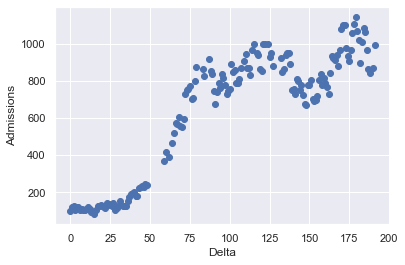

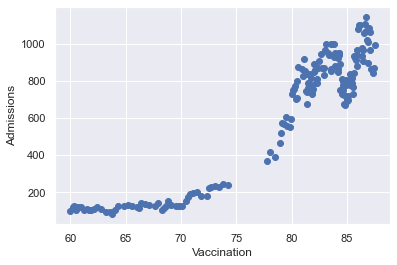

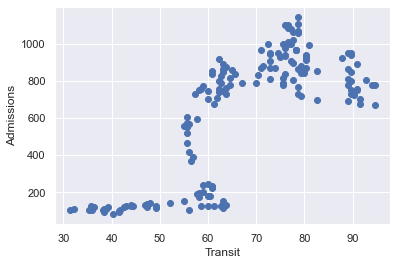

In [171]:
plt.scatter(df["Delta"], df["Admissions"])
plt.xlabel("Delta")
plt.ylabel("Admissions")
plt.show()

plt.scatter(df["Vaccination"], df["Admissions"])
plt.xlabel("Vaccination")
plt.ylabel("Admissions")
plt.show()

plt.scatter(df["Transit"], df["Admissions"])
plt.xlabel("Transit")
plt.ylabel("Admissions")
plt.show()

# =======================
# **Linear Regression**
# =======================
<a id="linear"></a>

In [172]:
df_feature_delta, df_target = get_features_targets(df, ["Delta"], ["Admissions"])
df_feature_vaccination, df_target = get_features_targets(df, ["Vaccination"], ["Admissions"])
df_feature_transit, df_target = get_features_targets(df, ["Transit"], ["Admissions"])

## **For Delta**

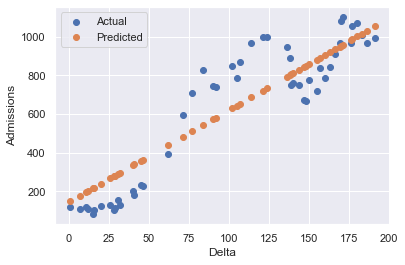

In [173]:
# Delta
df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_feature_delta, df_target)

# normalize features
df_features_train_z = normalize_z(df_features_train)

# change to numpy array and append column for feature
X = prepare_feature(df_features_train_z)
target = prepare_target(df_target_train)

iterations = 1500
alpha = 0.01
beta = np.zeros((2,1))

# call gradient_descent() function
beta, J_storage1 = gradient_descent(X, target, beta, alpha, iterations)

pred = predict(df_features_test, beta)

plt.scatter(df_features_test["Delta"], df_target_test, label="Actual")
plt.scatter(df_features_test["Delta"], pred, label="Predicted")
plt.ylabel("Admissions")
plt.xlabel("Delta")
plt.legend()

In [174]:
# TESTS
printBeta(beta)
target = prepare_target(df_target_test)

a_r2 = adjusted_r2_score(target, pred, beta.shape[0]-1)
print("The Adjusted R Squared Value is", round(a_r2, 2))

mse = root_mean_squared_error(target, pred)
print("The Root Mean Squared Error Value is", round(mse, 2))


The beta values are 629.15, 293.58.
The Adjusted R Squared Value is 0.84
The Root Mean Squared Error Value is 142.72


## **For Vaccination**

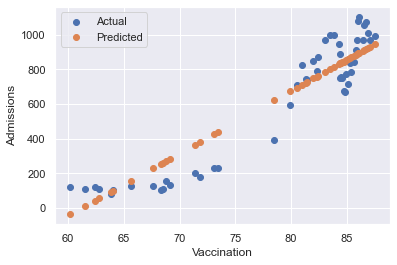

In [175]:
# Vaccination
df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_feature_vaccination, df_target)

# normalize features
df_features_train_z = normalize_z(df_features_train)

# change to numpy array and append column for feature
X = prepare_feature(df_features_train_z)
target = prepare_target(df_target_train)

iterations = 1500
alpha = 0.01
beta = np.zeros((2,1))

# call gradient_descent() function
beta, J_storage2 = gradient_descent(X, target, beta, alpha, iterations)

pred = predict(df_features_test, beta)

plt.scatter(df_features_test["Vaccination"], df_target_test, label="Actual")
plt.scatter(df_features_test["Vaccination"], pred, label="Predicted")
plt.ylabel("Admissions")
plt.xlabel("Vaccination")
plt.legend()

In [176]:
# TESTS
printBeta(beta)
target = prepare_target(df_target_test)

a_r2 = adjusted_r2_score(target, pred, beta.shape[0]-1)
print("The Adjusted R Squared Value is", round(a_r2, 2))

mse = root_mean_squared_error(target, pred)
print("The Root Mean Squared Error Value is", round(mse, 2))

The beta values are 629.15, 310.71.
The Adjusted R Squared Value is 0.88
The Root Mean Squared Error Value is 124.3


## **For Transit**

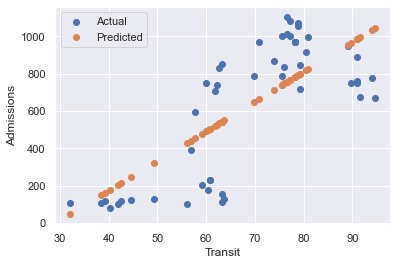

In [177]:
# Transit
df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_feature_transit, df_target)

# normalize features
df_features_train_z = normalize_z(df_features_train)

# change to numpy array and append column for feature
X = prepare_feature(df_features_train_z)
target = prepare_target(df_target_train)

iterations = 1500
alpha = 0.01
beta = np.zeros((2,1))

# call gradient_descent() function
beta, J_storage3 = gradient_descent(X, target, beta, alpha, iterations)

pred = predict(df_features_test, beta)

plt.scatter(df_features_test["Transit"], df_target_test, label="Actual")
plt.scatter(df_features_test["Transit"], pred, label="Predicted")
plt.ylabel("Admissions")
plt.xlabel("Transit")
plt.legend()

In [178]:
# TESTS
printBeta(beta)
target = prepare_target(df_target_test)

a_r2 = adjusted_r2_score(target, pred, beta.shape[0]-1)
print("The Adjusted R Squared Value is", round(a_r2, 2))

mse = root_mean_squared_error(target, pred)
print("The Root Mean Squared Error Value is", round(mse, 2))

The beta values are 629.15, 259.08.
The Adjusted R Squared Value is 0.57
The Root Mean Squared Error Value is 232.34



# =======================
# **Polynomial Linear Regression**
# =======================
<a id="linear"></a>
<a id="poly"></a>

## **For Delta**

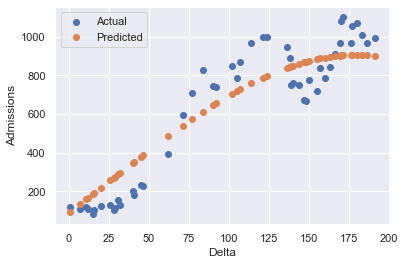

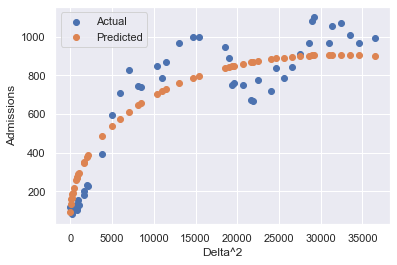

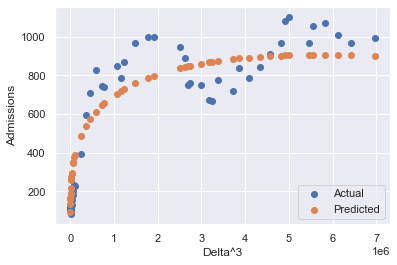

In [179]:
df_features_second = transform_features_power(df_feature_delta, 'Delta', 'Delta^2', 2)
df_features_second = transform_features_power(df_features_second, 'Delta', 'Delta^3', 3)
# print(df_features_second)

df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_features_second, df_target)

# normalize features
df_features_train_z = normalize_z(df_features_train)

# change to numpy array and append column for feature
X = prepare_feature(df_features_train_z)
target = prepare_target(df_target_train)

iterations = 1500
alpha = 0.01
beta = np.zeros((4,1))

# call gradient_descent() function
beta, J_storage4 = gradient_descent(X, target, beta, alpha, iterations)

pred = predict(df_features_test, beta)


plt.scatter(df_features_test["Delta"], df_target_test, label="Actual")
plt.scatter(df_features_test["Delta"], pred, label="Predicted")
plt.ylabel("Admissions")
plt.xlabel("Delta")
plt.legend()
plt.show()

plt.scatter(df_features_test["Delta^2"], df_target_test, label="Actual")
plt.scatter(df_features_test["Delta^2"], pred, label="Predicted")
plt.ylabel("Admissions")
plt.xlabel("Delta^2")
plt.legend()
plt.show()

plt.scatter(df_features_test["Delta^3"], df_target_test, label="Actual")
plt.scatter(df_features_test["Delta^3"], pred, label="Predicted")
plt.ylabel("Admissions")
plt.xlabel("Delta^3")
plt.legend()
plt.show()

In [180]:
# TESTS
printBeta(beta)
target = prepare_target(df_target_test)

a_r2 = adjusted_r2_score(target, pred, beta.shape[0]-1)
print("The Adjusted R Squared Value is", round(a_r2, 2))

mse = root_mean_squared_error(target, pred)
print("The Root Mean Squared Error Value is", round(mse, 2))

# 0.707 , 1.7, 5.5, 6

The beta values are 629.15, 401.29, 46.85, -178.89.
The Adjusted R Squared Value is 0.86
The Root Mean Squared Error Value is 130.17


## **For Vaccination**

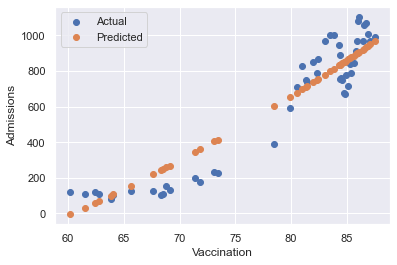

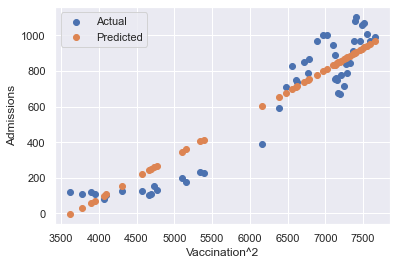

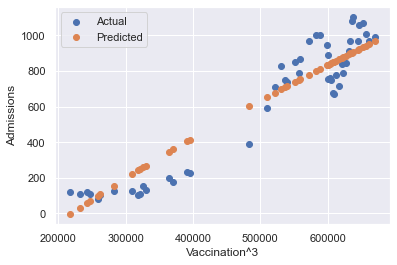

In [181]:
df_features_second = transform_features_power(df_feature_vaccination, 'Vaccination', 'Vaccination^2', 2)
df_features_second = transform_features_power(df_features_second, 'Vaccination', 'Vaccination^3', 3)

# print(df_features_second)

df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_features_second, df_target)

# normalize features
df_features_train_z = normalize_z(df_features_train)

# change to numpy array and append column for feature
X = prepare_feature(df_features_train_z)
target = prepare_target(df_target_train)

iterations = 1500
alpha = 0.01
beta = np.zeros((4,1))

# call gradient_descent() function
beta, J_storage5 = gradient_descent(X, target, beta, alpha, iterations)

pred = predict(df_features_test, beta)


plt.scatter(df_features_test["Vaccination"], df_target_test, label="Actual")
plt.scatter(df_features_test["Vaccination"], pred, label="Predicted")
plt.ylabel("Admissions")
plt.xlabel("Vaccination")
plt.legend()
plt.show()

plt.scatter(df_features_test["Vaccination^2"], df_target_test, label="Actual")
plt.scatter(df_features_test["Vaccination^2"], pred, label="Predicted")
plt.ylabel("Admissions")
plt.xlabel("Vaccination^2")
plt.legend()
plt.show()

plt.scatter(df_features_test["Vaccination^3"], df_target_test, label="Actual")
plt.scatter(df_features_test["Vaccination^3"], pred, label="Predicted")
plt.ylabel("Admissions")
plt.xlabel("Vaccination^3")
plt.legend()
plt.show()

In [182]:
# TESTS
printBeta(beta)
target = prepare_target(df_target_test)

a_r2 = adjusted_r2_score(target, pred, beta.shape[0]-1)
print("The Adjusted R Squared Value is", round(a_r2, 2))

mse = root_mean_squared_error(target, pred)
print("The Root Mean Squared Error Value is", round(mse, 2))

The beta values are 629.15, 82.05, 105.24, 125.43.
The Adjusted R Squared Value is 0.88
The Root Mean Squared Error Value is 117.56


## **For Transit**

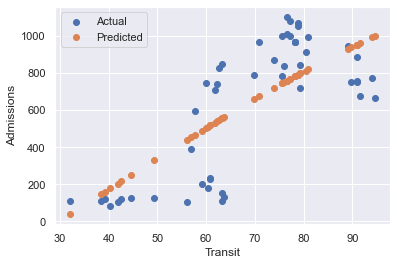

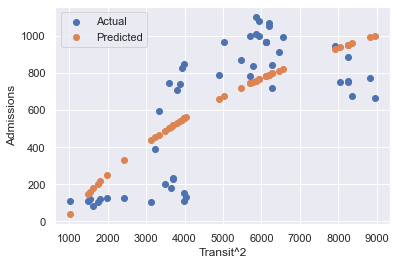

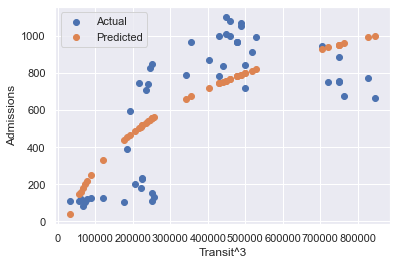

In [183]:
df_features_second = transform_features_power(df_feature_transit, 'Transit', 'Transit^2', 2)
df_features_second = transform_features_power(df_features_second, 'Transit', 'Transit^3', 3)

# print(df_features_second)

df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_features_second, df_target)

# normalize features
df_features_train_z = normalize_z(df_features_train)

# change to numpy array and append column for feature
X = prepare_feature(df_features_train_z)
target = prepare_target(df_target_train)

iterations = 1500
alpha = 0.01
beta = np.zeros((4,1))

# call gradient_descent() function
beta, J_storage6 = gradient_descent(X, target, beta, alpha, iterations)

pred = predict(df_features_test, beta)

plt.scatter(df_features_test["Transit"], df_target_test, label="Actual")
plt.scatter(df_features_test["Transit"], pred, label="Predicted")
plt.ylabel("Admissions")
plt.xlabel("Transit")
plt.legend()
plt.show()

plt.scatter(df_features_test["Transit^2"], df_target_test, label="Actual")
plt.scatter(df_features_test["Transit^2"], pred, label="Predicted")
plt.ylabel("Admissions")
plt.xlabel("Transit^2")
plt.legend()
plt.show()

plt.scatter(df_features_test["Transit^3"], df_target_test, label="Actual")
plt.scatter(df_features_test["Transit^3"], pred, label="Predicted")
plt.ylabel("Admissions")
plt.xlabel("Transit^3")
plt.legend()
plt.show()

In [184]:
# TESTS
printBeta(beta)
target = prepare_target(df_target_test)

a_r2 = adjusted_r2_score(target, pred, beta.shape[0]-1)
print("The Adjusted R Squared Value is", round(a_r2, 2))

mse = root_mean_squared_error(target, pred)
print("The Root Mean Squared Error Value is", round(mse, 2))

The beta values are 629.15, 257.91, 84.48, -94.72.
The Adjusted R Squared Value is 0.56
The Root Mean Squared Error Value is 228.61


# =======================
# **Multiple Regression**
# =======================
<a id="linear"></a>
<a id="multi"></a>

## Delta VS Admissions

In [185]:
df_task2 = pd.read_csv("DDW_Task2.csv")

df_features, df_target = get_features_targets(df_task2, ["Delta"], ["Admissions"])
df_features_visual = normalize_z(df_features)

df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_features, df_target)

# normalize features
df_features_train_z = normalize_z(df_features_train)

# change to numpy array and append column for feature
X = prepare_feature(df_features_train_z)
target = prepare_target(df_target_train)

iterations = 1500
alpha = 0.01
beta = np.zeros((2,1))

# call gradient_descent() function
beta, J_storage7 = gradient_descent(X, target, beta, alpha, iterations)

pred = predict(df_features_test, beta)

# TESTS
printBeta(beta)
target = prepare_target(df_target_test)

a_r2 = adjusted_r2_score(target, pred, beta.shape[0]-1)
print("The Adjusted R Squared Value is", round(a_r2, 2))

mse = root_mean_squared_error(target, pred)
print("The Root Mean Squared Error Value is", round(mse, 2))


The beta values are 629.15, 293.58.
The Adjusted R Squared Value is 0.84
The Root Mean Squared Error Value is 142.72


## Delta, Vaccination VS Admissions

In [186]:
df_task2 = pd.read_csv("DDW_Task2.csv")

df_features, df_target = get_features_targets(df_task2, ["Vaccination", "Delta"], ["Admissions"])
df_features_visual = normalize_z(df_features)

df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_features, df_target)

# normalize features
df_features_train_z = normalize_z(df_features_train)

# change to numpy array and append column for feature
X = prepare_feature(df_features_train_z)
target = prepare_target(df_target_train)

iterations = 1500
alpha = 0.01
beta = np.zeros((3,1))

# call gradient_descent() function
beta, J_storage7 = gradient_descent(X, target, beta, alpha, iterations)

pred = predict(df_features_test, beta)

# TESTS
printBeta(beta)
target = prepare_target(df_target_test)

a_r2 = adjusted_r2_score(target, pred, beta.shape[0]-1)
print("The Adjusted R Squared Value is", round(a_r2, 2))

mse = root_mean_squared_error(target, pred)
print("The Root Mean Squared Error Value is", round(mse, 2))


The beta values are 629.15, 234.69, 78.84.
The Adjusted R Squared Value is 0.88
The Root Mean Squared Error Value is 120.17


## Delta, Vaccination, Transit VS Admissions

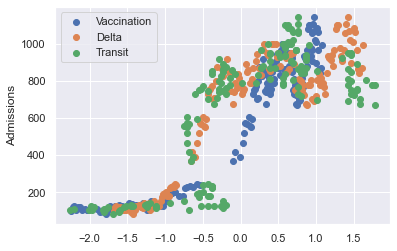

In [187]:
df_features, df_target = get_features_targets(df_task2, ["Vaccination", "Delta", "Transit"], ["Admissions"])

df_features_visual = normalize_z(df_features)

plt.scatter(df_features_visual["Vaccination"], df_target, label="Vaccination")
plt.scatter(df_features_visual["Delta"], df_target, label="Delta")
plt.scatter(df_features_visual["Transit"], df_target, label="Transit")
plt.ylabel("Admissions")
plt.legend()
plt.show()


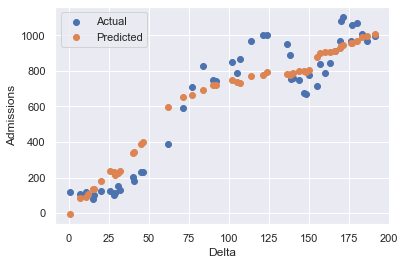

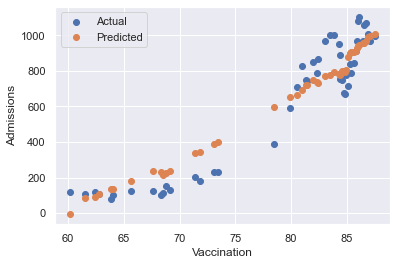

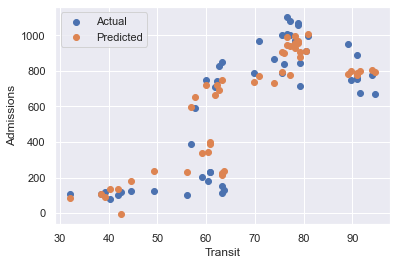

In [188]:
df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_features, df_target)

# normalize features
df_features_train_z = normalize_z(df_features_train)

# change to numpy array and append column for feature
X = prepare_feature(df_features_train_z)
target = prepare_target(df_target_train)

iterations = 1500
alpha = 0.01
beta = np.zeros((4,1))

# call gradient_descent() function
beta, J_storage7 = gradient_descent(X, target, beta, alpha, iterations)

pred = predict(df_features_test, beta)

plt.scatter(df_features_test["Delta"], df_target_test, label="Actual")
plt.scatter(df_features_test["Delta"], pred, label="Predicted")
plt.ylabel("Admissions")
plt.xlabel("Delta")
plt.legend()
plt.show()

plt.scatter(df_features_test["Vaccination"], df_target_test, label="Actual")
plt.scatter(df_features_test["Vaccination"], pred, label="Predicted")
plt.ylabel("Admissions")
plt.xlabel("Vaccination")
plt.legend()
plt.show()

plt.scatter(df_features_test["Transit"], df_target_test, label="Actual")
plt.scatter(df_features_test["Transit"], pred, label="Predicted")
plt.ylabel("Admissions")
plt.xlabel("Transit")
plt.legend()
plt.show()

In [189]:
# TESTS
printBeta(beta)
target = prepare_target(df_target_test)

a_r2 = adjusted_r2_score(target, pred, beta.shape[0]-1)
print("The Adjusted R Squared Value is", round(a_r2, 2))

mse = root_mean_squared_error(target, pred)
print("The Root Mean Squared Error Value is", round(mse, 2))

The beta values are 629.15, 261.0, 109.13, -63.53.
The Adjusted R Squared Value is 0.9
The Root Mean Squared Error Value is 109.88


# Model Evaluation


## Steps taken to improve accuracy of model
1. Adjusting the power of polynomial linear regression model (up till highest power 6)
2. Removing outliers (above standard error 1.5)
3. Tried modelling with other possible features:<br/>
    i) Number of Covid Tests Daily<br/> 
    ii) Number of visitors to Places of Retail and Recreation
4. Calculating R Squared value for target and individual features to ensure correlationship
5. Add and remove data from dataset (changing the time period from which data was extracted)
6. Transformation for "Number of visitors to Transit Areas" into positive values

## Discussion on Models & Result

To summarise:

Linear Regression Model Adjusted R Squared:

1. Hospital Admission vs Number of days from introduction of Delta Variant: 0.84
2. Hospital Admission vs Vaccination rate: 0.88
3. Hospital Admission vs Number of visitors to Transit Areas: 0.57

Polynomial Regression Model Adjusted R Squared:

1. Hospital Admission vs Number of days from introduction of Delta Variant: 0.86
2. Hospital Admission vs Vaccination rate: 0.88
3. Hospital Admission vs Number of visitors to Transit Areas: 0.56

We saw an increase in Adjusted R Square Value each time a new feature is added to our model.

1. Delta VS Admissions: 0.84
2. Delta, Vaccination VS Admissions: 0.88
3. Delta, Vaccination, Transit VS Admissions: 0.9

Since the number of hospital admissions can be affected multiple factors at the same time, we decided to use **Multiple Regression Model** to predict our target. Multiple Regression Model is more practical in producing prediction with higher credibility compared to Linear and Polynomial Regression Model. Additionally, the cost of Multiple Regression Model is the lowest among all models we have experimented with. This shows that the Multiple Regression Model gives the most accurate prediction.



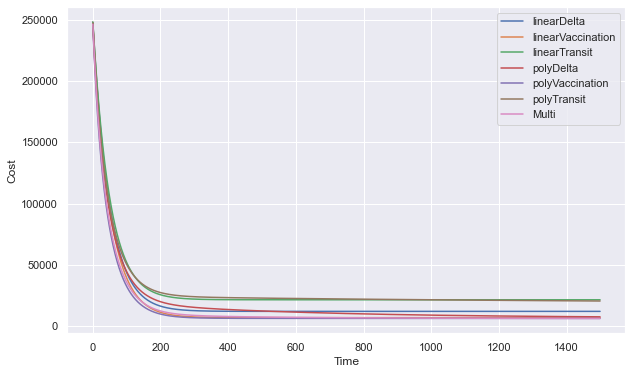

In [190]:
plt.figure(figsize=(10, 6))
plt.plot(J_storage1, label="linearDelta")
plt.plot(J_storage2, label="linearVaccination")
plt.plot(J_storage3, label="linearTransit")
plt.plot(J_storage4, label="polyDelta")
plt.plot(J_storage5, label="polyVaccination")
plt.plot(J_storage6, label="polyTransit")
plt.plot(J_storage7, label="Multi")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Cost")
plt.show()